In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:\\Career\\GradProj\\New deal\\Dataset\\parkinson_data.csv')
df.drop('Unnamed: 0', axis = 1,inplace=True)

df.columns = ['Time',
 'AccV',
 'AccML',
 'AccAP',
 'StartHesitation',
 'Turn',
 'Walking',
 'idx',
 'ID',
 'len_df']

In [3]:
df_bu = df.copy()

In [4]:


df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)
df[['normal','fog']] = pd.get_dummies(df['class'], prefix='class')


# Compute the mean and standard deviation of the dataset
data = np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float64)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

df[['AccV','AccML','AccAP']] = abs((data - mean) / std)

<AxesSubplot:>

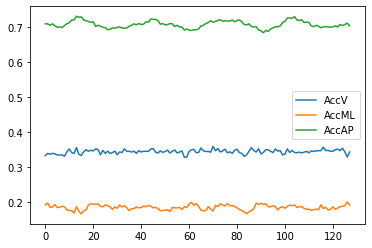

In [5]:
df[['AccV','AccML','AccAP']][0:128].plot()

In [6]:
x_win = []
y_win = []

x = df[['AccV','AccML','AccAP']]
y = df[['fog','normal']]

for i in range(0,len(df)-len(df)%1500,750):
    x_win.append(x[i:i+1500])
    y_win.append(y[i:i+1500])
    
x_win.pop()
y_win.pop()
x_win = np.asarray(x_win,dtype = np.float32)
y_win = np.asarray(y_win,dtype = int)

In [7]:
from scipy import stats
y_win_s2l = []
for i in y_win:
    y_win_s2l.append(stats.mode(i)[0][0])
y_win_s2l = np.asarray(y_win_s2l,dtype = int)

In [8]:
y_win.shape, y_win_s2l.shape

((9415, 1500, 2), (9415, 2))

In [9]:
x_win_aug = []
y_win_aug = []
for i in range(len(y_win)):
    x_win_aug.append(x_win[i])
    y_win_aug.append(y_win[i])
    
    if y_win_s2l[i,0]==1:
        x_win_aug.append(x_win[i])
        y_win_aug.append(y_win[i])
x_win_aug = np.asarray(x_win_aug,dtype = np.float32)
y_win_aug = np.asarray(y_win_aug,dtype = int)

In [10]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [11]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        print(' - lr:',model.optimizer._decayed_lr(tf.float32).numpy(),'Fold number:',k)

In [12]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)
models = []
evals = []
k = 0
rlr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-4,decay_steps=70*3,decay_rate=0.96,staircase=True)
xavier = tf.keras.initializers.GlorotNormal(seed=None)

In [13]:
for train, test in kfold.split(x_win_aug, y_win_aug):
    x_train, x_val, y_train, y_val = train_test_split(x_win_aug[train], y_win_aug[train], test_size=0.10)

    model = Sequential([
        LSTM(100, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),kernel_initializer = xavier, bias_regularizer=regularizers.L2(1e-4), input_shape=(1500,3), return_sequences = True ),
        Dropout(0.2),

        Dense(2, activation = 'softmax') 
    ])
    
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = rlr, clipvalue=1),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'best_{k}.hdf5', verbose=0, save_best_only=True,monitor='val_accuracy',mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger(f"history_log_{k}.csv")

    model.fit(x_train, y_train, batch_size = 256, epochs = 500, callbacks = [earlystop,checkpointer,csv_logger,CustomCallback(),],validation_data=(x_val,y_val))
    model = tf.keras.models.load_model(f'best_{k}.hdf5')
    models.append(model)
    evals.append(model.evaluate(x_win_aug[test],y_win_aug[test]))
    
    k+=1

Epoch 1/500
35/35 [==============================] - 16s 384ms/step - loss: 0.7079 - accuracy: 0.5121 - val_loss: 0.6927 - val_accuracy: 0.5878
Epoch 2/500
35/35 [==============================] - 15s 430ms/step - loss: 0.6916 - accuracy: 0.5590 - val_loss: 0.6807 - val_accuracy: 0.5812
Epoch 3/500
35/35 [==============================] - 15s 433ms/step - loss: 0.6781 - accuracy: 0.5766 - val_loss: 0.6660 - val_accuracy: 0.5942
Epoch 4/500
35/35 [==============================] - 15s 432ms/step - loss: 0.6541 - accuracy: 0.6060 - val_loss: 0.6285 - val_accuracy: 0.6314
Epoch 5/500
35/35 [==============================] - 15s 429ms/step - loss: 0.5968 - accuracy: 0.6655 - val_loss: 0.5746 - val_accuracy: 0.6842
Epoch 6/500
35/35 [==============================] - 15s 432ms/step - loss: 0.5674 - accuracy: 0.6926 - val_loss: 0.5429 - val_accuracy: 0.7087
Epoch 7/500
35/35 [==============================] - 15s 429ms/step - loss: 0.5537 - accuracy: 0.7057 - val_loss: 0.5357 - val_accuracy:

c:\ProgramData\Anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/500
35/35 [==============================] - 17s 438ms/step - loss: 0.7027 - accuracy: 0.5128 - val_loss: 0.6939 - val_accuracy: 0.5426
Epoch 2/500
35/35 [==============================] - 15s 432ms/step - loss: 0.6907 - accuracy: 0.5478 - val_loss: 0.6859 - val_accuracy: 0.5562
Epoch 3/500
35/35 [==============================] - 15s 428ms/step - loss: 0.6808 - accuracy: 0.5641 - val_loss: 0.6723 - val_accuracy: 0.5758
Epoch 4/500
35/35 [==============================] - 15s 431ms/step - loss: 0.6507 - accuracy: 0.6021 - val_loss: 0.6062 - val_accuracy: 0.6466
Epoch 5/500
35/35 [==============================] - 15s 432ms/step - loss: 0.5851 - accuracy: 0.6764 - val_loss: 0.5715 - val_accuracy: 0.6901
Epoch 6/500
35/35 [==============================] - 15s 434ms/step - loss: 0.5808 - accuracy: 0.6832 - val_loss: 0.5559 - val_accuracy: 0.7037
Epoch 7/500
35/35 [==============================] - 15s 434ms/step - loss: 0.5609 - accuracy: 0.6991 - val_loss: 0.5459 - val_accuracy:

In [14]:
import tensorflow_addons as tfa
# x_win_aug[test],y_win_s2l_aug[test]
f1 = []
recalls = []
precisions = []
k = 0
kfold = KFold(n_splits=5, shuffle=False)
for train, test in kfold.split(x_win_aug, y_win_aug):
    metric = tfa.metrics.F1Score(num_classes=2,threshold=0.5)

    y_true = y_win_aug[test]
    y_pred = models[k].predict(x_win_aug[test])

    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    recalls.append(recall.result().numpy())
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    precisions.append(precision.result().numpy())
    k+=1
    break
f1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))

c:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


77/77 [==============================] - 4s 43ms/step


In [15]:
import pickle
file1 = open('evaluations', 'wb')
file2 = open('models', 'wb')
file3 = open('scores', 'wb')
pickle.dump(evals, file1)
pickle.dump(models, file2)
pickle.dump([f1,recalls,precisions], file3)
file1.close()
file2.close()
file3.close()

INFO:tensorflow:Assets written to: ram://f3164b49-0c71-4d3a-8a52-701d11caaf85/assets


INFO:tensorflow:Assets written to: ram://f3164b49-0c71-4d3a-8a52-701d11caaf85/assets


INFO:tensorflow:Assets written to: ram://32caa22a-58c5-4180-8e3e-93782ea503c3/assets


INFO:tensorflow:Assets written to: ram://32caa22a-58c5-4180-8e3e-93782ea503c3/assets


INFO:tensorflow:Assets written to: ram://94b48440-6748-4104-a60d-f1025849860b/assets


INFO:tensorflow:Assets written to: ram://94b48440-6748-4104-a60d-f1025849860b/assets


INFO:tensorflow:Assets written to: ram://90278435-7db4-455a-88a7-524e58fc085b/assets


INFO:tensorflow:Assets written to: ram://90278435-7db4-455a-88a7-524e58fc085b/assets


INFO:tensorflow:Assets written to: ram://3a739bfe-1675-4cc0-9c10-6790347dc60e/assets


INFO:tensorflow:Assets written to: ram://3a739bfe-1675-4cc0-9c10-6790347dc60e/assets
